# Greedy Backward Feature Selection

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

%matplotlib inline

## Data Handling

In [2]:
df = pd.read_csv("../data/FODS-A2.csv")
df.head()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
0,21.20,33.290,19.823333,31.790000,23.463333,38.230000,20.50,31.73,19.200000,39.363333,...,29.230000,9.85,756.183333,41.833333,4.833333,40.0,-2.67,42.017180,42.017180,290
1,21.79,38.500,19.500000,40.633333,22.500000,37.900000,21.00,37.90,20.033333,47.290000,...,40.326667,6.90,754.000000,75.000000,4.000000,40.0,2.80,24.624380,24.624380,50
2,22.39,41.390,20.200000,43.790000,24.500000,39.333333,20.10,38.26,19.390000,48.090000,...,42.060000,10.10,756.433333,68.000000,5.833333,40.0,4.45,3.731260,3.731260,260
3,24.00,30.260,24.390000,26.963333,23.390000,33.400000,22.79,31.20,21.033333,40.626667,...,35.500000,19.10,760.000000,31.000000,4.000000,40.0,1.50,1.058826,1.058826,50
4,20.05,38.245,17.600000,41.000000,21.100000,37.200000,19.89,36.40,18.200000,43.560000,...,38.863333,0.10,754.600000,99.000000,1.000000,32.0,-0.10,39.248108,39.248108,30


### Shuffling dataset and Train-Test Split

In [3]:
## Data Handling# Shuffling the dataset
shuffled_df = df.sample(frac=1, random_state=100)

# Define a size for your train set
training_data_size = int(0.8 * len(df))

# Split your dataset
training_data = shuffled_df[:training_data_size]
testing_data = shuffled_df[training_data_size:]

In [4]:
X_train = training_data.drop("Appliances", axis=1)
X_test = testing_data.drop("Appliances", axis=1)
y_train = training_data["Appliances"]
y_test = testing_data["Appliances"]

In [5]:
X_train = X_train.to_numpy().reshape(X_train.shape[1], X_train.shape[0])
X_test = X_test.to_numpy().reshape(X_test.shape[1], X_test.shape[0])
y_train = y_train.to_numpy().reshape(1, -1)
y_test = y_test.to_numpy().reshape(1, -1)

In [6]:
X_tr = training_data.drop("Appliances", axis=1)
X_te = testing_data.drop("Appliances", axis=1)
y_tr = training_data["Appliances"]
y_te = testing_data["Appliances"]

## Gradient Descent

In [7]:
def pol_feat(mat, deg):
    if deg == 1:
        mat = mat.to_numpy()
        m, n = mat.shape
        return mat.reshape(n, m), n

In [8]:
def get_cost(y, t):
    return 0.5 * np.sum(np.power((t - y), 2)) / y.shape[1]

In [9]:
def gradient_descent(num_epochs, X, t, theta, bias, lr):
    # forward-prop
    costs = []
    for iter in range(num_epochs):
        y = np.dot(theta, X) + bias

        loss = get_cost(y, t)
        # print(loss)
        costs.append(loss)

        # backprop
        der = (1 / y.shape[1]) * np.dot(y - t, X.T)

        dBias = (1 / y.shape[1]) * np.sum((y - t))

        # updation
        # theta = theta - (learning_rate/y.shape[1]) * np.sum(X * ((predicted(X,theta)) - y), axis=0)
        theta = theta - lr * der
        bias = bias - lr * dBias

    return costs, theta, bias

In [10]:
def fwd_prop_test(X, theta, bias):
    y = np.dot(theta, X) + bias
    loss = get_cost(y, y_test)
    return loss

In [11]:
def initialize(dim):
    np.random.seed(42)
    b = random.random()
    theta = np.random.rand(1, dim) * 0.01
    return b, theta

In [12]:
final_trainerror_BGD = []
final_testerror_BGD = []
biasarr_bgd = [0] * 10
weightsarr_bgd = [0] * 10
ctr_bgd = 0
ctr_sgd = 0

In [13]:
features = []
columns = list(X_tr.columns)
features.append(columns)

train_global = []
test_global = []
weights_global = []
bias_global = []

## Feature Selection

In [14]:
def greedy_backward():
    train_local = []
    test_local = []
    weight_local = []
    bias_local = []
    f_final = []
    if len(weights_global) == 0:
        data, num_features = pol_feat(X_tr, 1)
        test_data, num_test_features = pol_feat(X_te, 1)
        mean = np.mean(data, axis=1, keepdims=True)
        stddev = np.std(data, axis=1, keepdims=True)
        data = (data - mean) / stddev
        test_data = (test_data - mean) / stddev
        bias, weights = initialize(num_features)
        BGD_MSE_train, weights, bias = gradient_descent(
            1000, data, y_train, weights, bias, 0.00001
        )
        BGD_MSE_test = fwd_prop_test(test_data, weights, bias)
        train_local.append(BGD_MSE_train[-1])
        test_local.append(BGD_MSE_test)
        weight_local.append(weights)
        bias_local.append(bias)
        f_final.append(X_tr.columns)

    else:

        for col in features[-1]:
            data, num_features = pol_feat(X_tr[features[-1]].drop(col, axis=1), 1)
            test_data, num_test_features = pol_feat(
                X_te[features[-1]].drop(col, axis=1), 1
            )
            mean = np.mean(data, axis=1, keepdims=True)
            stddev = np.std(data, axis=1, keepdims=True)
            data = (data - mean) / stddev
            test_data = (test_data - mean) / stddev
            bias, weights = initialize(num_features)
            BGD_MSE_train, weights, bias = gradient_descent(
                1000, data, y_train, weights, bias, 0.00001
            )
            BGD_MSE_test = fwd_prop_test(test_data, weights, bias)
            train_local.append(BGD_MSE_train[-1])
            test_local.append(BGD_MSE_test)
            weight_local.append(weights)
            bias_local.append(bias)

            f_final.append((X_tr[features[-1]].drop(col, axis=1).columns))

    return f_final, train_local, test_local, weight_local, bias_local

### Implementation

In [15]:
f_26, train_26, test_26, weight_26, bias_26 = greedy_backward()

In [16]:
train_global.append(train_26[0])
test_global.append(test_26[0])
weights_global.append(weight_26[0])
bias_global.append(bias_26[0])

In [17]:
for i in range(1, 26):
    f_i = []
    bias_i = []
    weight_i = []
    test_i = []
    train_i = []
    f_i, train_i, test_i, weight_i, bias_i = greedy_backward()
    weights_global.append(weight_i[test_i.index(min(test_i))])
    bias_global.append(bias_i[test_i.index(min(test_i))])
    test_global.append(test_i[test_i.index(min(test_i))])
    features.append(f_i[test_i.index(min(test_i))])
    train_global.append(train_i[test_i.index(min(test_i))])

### Results

In [18]:
test_global.index(min(test_global))

3

In [19]:
features[test_global.index(min(test_global))]

Index(['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6',
       'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg',
       'RH_out', 'Windspeed', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [21]:
print(
    f"Regression with all 26 features has: \nTraining error = {train_global[0]}\nTesting error = {test_global[0]}"
)

Regression with all 26 features has: 
Training error = 10008.805096158274
Testing error = 10773.083714839828


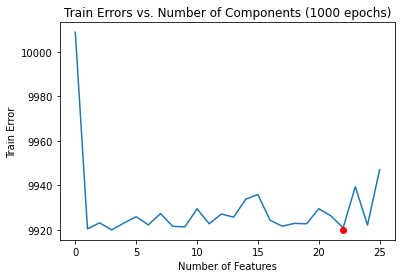

In [25]:
plt.plot(train_global)
plt.plot(25 - train_global.index(min(train_global[0:])), min(train_global[0:]), "ro")
plt.title("Train Errors vs. Number of Components (1000 epochs)")
plt.xlabel("Number of Features")
plt.ylabel("Train Error")
plt.savefig("../results/Train_Errors_Plot_backward.jpg")
plt.show()

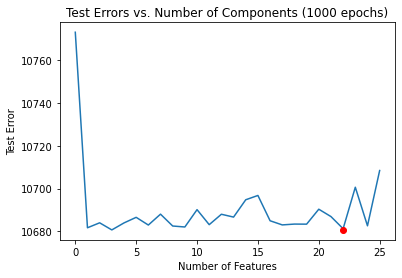

In [26]:
plt.plot(test_global)
plt.plot(25 - test_global.index(min(test_global[0:])), min(test_global[0:]), "ro")
plt.title("Test Errors vs. Number of Components (1000 epochs)")
plt.xlabel("Number of Features")
plt.ylabel("Test Error")
plt.savefig("../results/Test_Errors_Plot_backward.jpg")
plt.show()

In [24]:
results = pd.DataFrame(columns=("Number of Components", "Train Error", "Test Error"))
results["Number of Components"] = [i for i in range(26, 0, -1)]
results["Train Error"] = train_global
results["Test Error"] = test_global
results.set_index("Number of Components")
results.to_excel("../results/Results_backward.xlsx")
results

,Number of Components,Train Error,Test Error
0,26,10008.805096,10773.083715
1,25,9920.418818,10681.667527
2,24,9923.155755,10683.986858
3,23,9919.971240,10680.663231
4,22,9923.099314,10683.932885
5,21,9925.893619,10686.547351
6,20,9922.244078,10682.944834
7,19,9927.315794,10688.031011
8,18,9921.593948,10682.487795
9,17,9921.316239,10682.032718
